# 02 | Analysis - MST

Analysis of spectral features of resting-state EEG from 23 patients who received MST. This notebook performs statistical analysis and visualization of these features and how they change pre- and post-MST.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from scipy.stats import zscore
from pingouin import ttest, normality, wilcoxon
from cliffs_delta import cliffs_delta

from mst_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
%matplotlib inline

In [3]:
def compute_abundance(df, feature=''):
    """computes abundance as the number of channels containing an oscillation/total channels
    Parameters
    ----------
    Returns
    -------
    """
    features = ['patient','pre_post','channel', feature+'_cf']
    df_osc = pd.DataFrame(df[features])
    df_osc[f'{feature}_present'] = df_osc[feature+'_cf'].notna()
    ch_osc = df_osc.groupby(['patient', 'pre_post'])[f'{feature}_present'].sum().values
    ch_total = df_osc.groupby(['patient', 'pre_post'])['channel'].count().values
    ch_osc_perc = ch_osc/ch_total
    osc_perc_df = pd.DataFrame(df_osc.groupby(['patient', 'pre_post'], as_index=False)[f'{feature}_present'].sum())
    osc_perc_df[f'ch_{feature}_perc'] = ch_osc_perc
    
    return osc_perc_df

## 1. load data

In [4]:
# load dataframe
eeg_df = pd.read_csv('../saved_files/mst_files/mst_all_features.csv', index_col = 0)

# Exclude channels from ppn's with bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# load specparam fits for plotting
fits_pre = np.load('../saved_files/mst_files/mst_fits_pre.npy')
fits_post = np.load('../saved_files/mst_files/mst_fits_post.npy')
freq_axis = np.load('../saved_files/mst_files/mst_freq_axis.npy')

# load raw spectra for plotting
psd_pre = np.load('../saved_files_appeal/mst_files/pre_mst_psd.npy')
psd_post = np.load('../saved_files_appeal/mst_files/post_mst_psd.npy')

**Delete excluded electrodes per patient in the model fits**

In order to do this, we load the dataframe (eeg_df_included) and the fits (fits_pre, fits_post).
Then, we need to reshape the fits to match the dataframe.
After excluding the fits, we will reshape it back to its’ original shape.

In [5]:
# Get boolean area with True to exclude channels from patients
to_exclude_pre = eeg_df['exclude'][eeg_df['pre_post']=='pre'].values
to_exclude_post = eeg_df['exclude'][eeg_df['pre_post']=='post'].values

# Reshape fits array from [NUM_PATIENTS, NUM_CHANNELS, NUM_FREQS] --> [NUM_PATIENTS * NUM_CHANNELS, NUM_FREQS]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# Replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# Reshape back to original array from  [NUM_PATIENTS * NUM_CHANNELS, NUM_FREQS] --> [NUM_PATIENTS, NUM_CHANNELS, NUM_FREQS]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

## 2. Vizualize average EEG features

EEG features for each subject are averaged over all electrodes, plotted for pre- and post-MST.

In [6]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

In [7]:
# compute abundance of oscillations
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

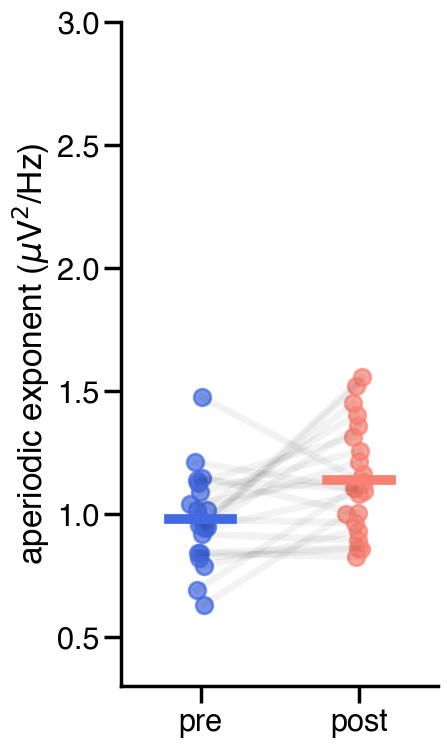

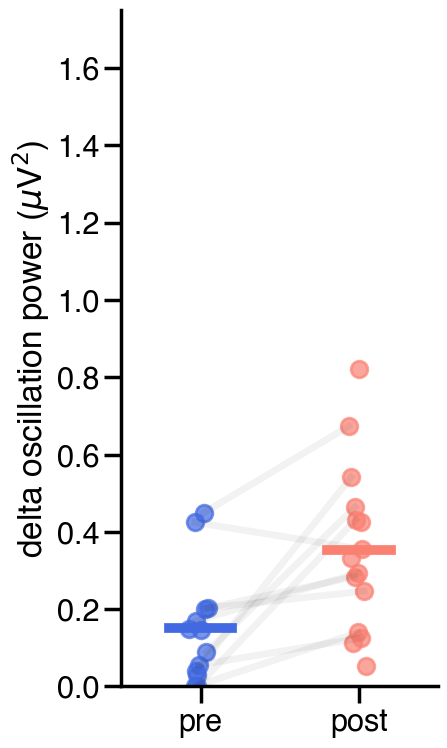

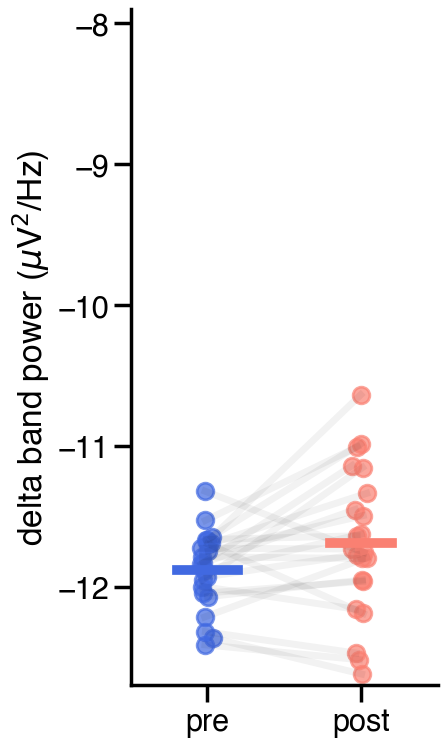

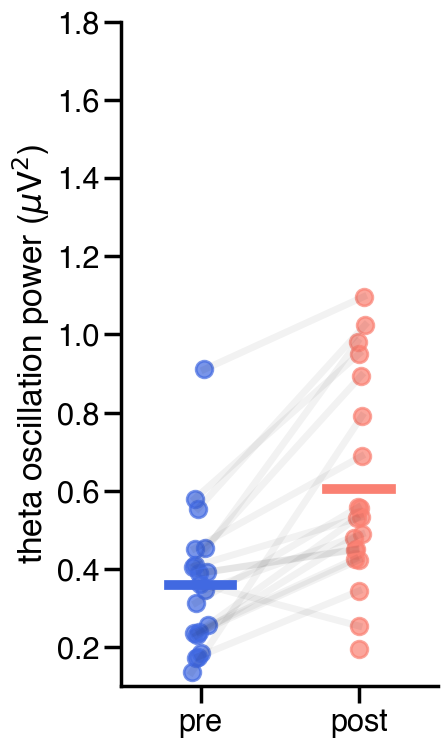

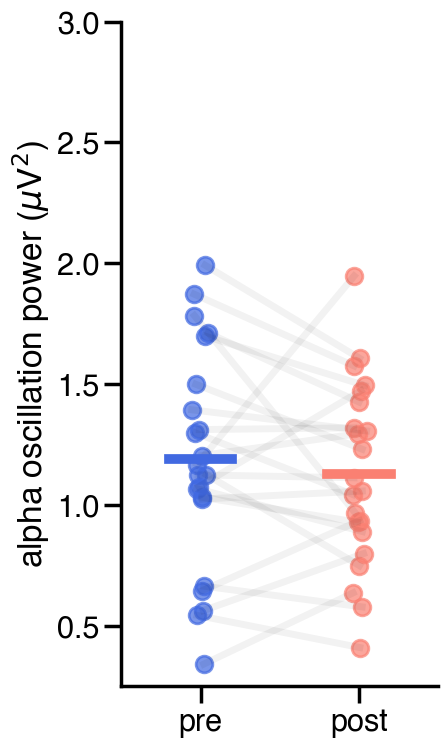

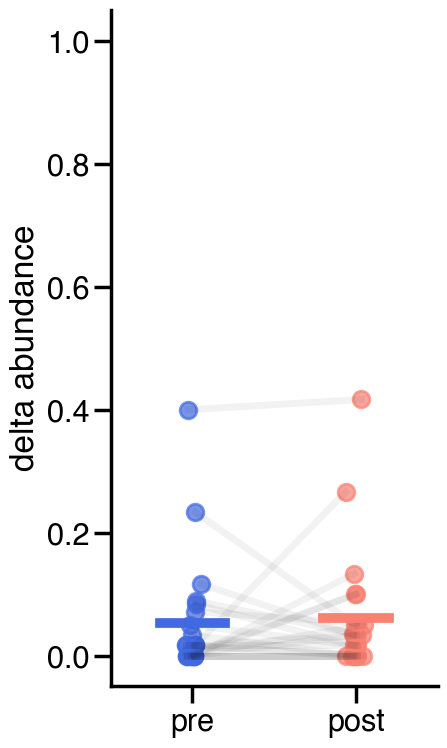

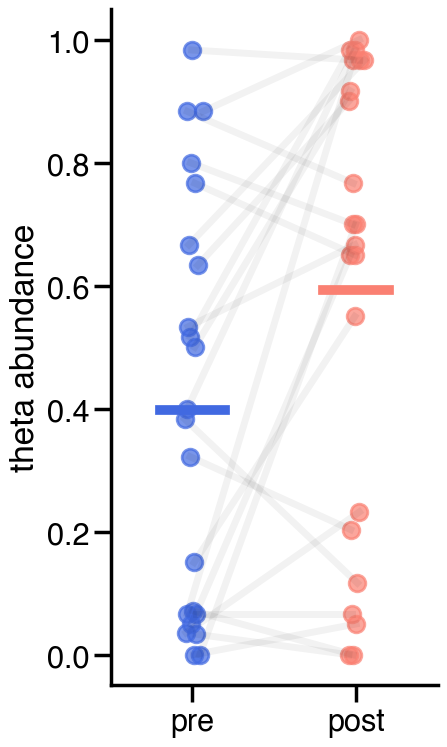

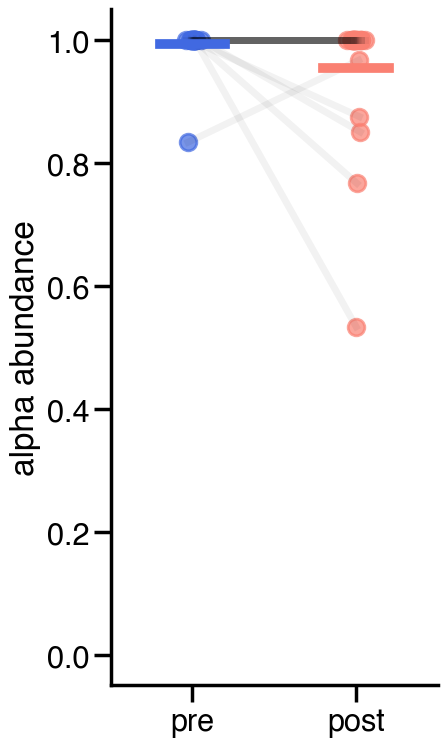

In [8]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'delta_amp', 'delta_bp', 'theta_amp', 'alpha_amp',
            'ch_delta_perc', 'ch_theta_perc', 'ch_alpha_perc']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'delta oscillation power ($\mu$V$^2$)',
          'delta band power ($\mu$V$^2$/Hz)', 'theta oscillation power ($\mu$V$^2$)', 
          'alpha oscillation power ($\mu$V$^2$)', 'delta abundance', 'theta abundance', 'alpha abundance']

ylims = [[0.3, 3.0], [0, 1.75], [-12.7, -7.9], [0.1, 1.8], [0.25, 3.0], [-0.05,1.05], [-0.05,1.05], [-0.05,1.05]]

for feature, label, ylim in zip(features, labels, ylims):
    plot_feature_prepost(eeg_df_mean, feature=feature)
    plt.ylabel(label)
    plt.ylim(ylim)
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

## 3. Visualize rsEEG power spectra

Plot pre- and post-MST power spectra of:
1. the specparam model fits and 
2. the raw rsEEG data.

In [9]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_14818/1731462785.py:1: RuntimeWarning: Mean of empty slice
  fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_14818/1731462785.py:2: RuntimeWarning: Mean of empty slice
  fits_post_mean = np.nanmean(fits_post_included, axis=1)


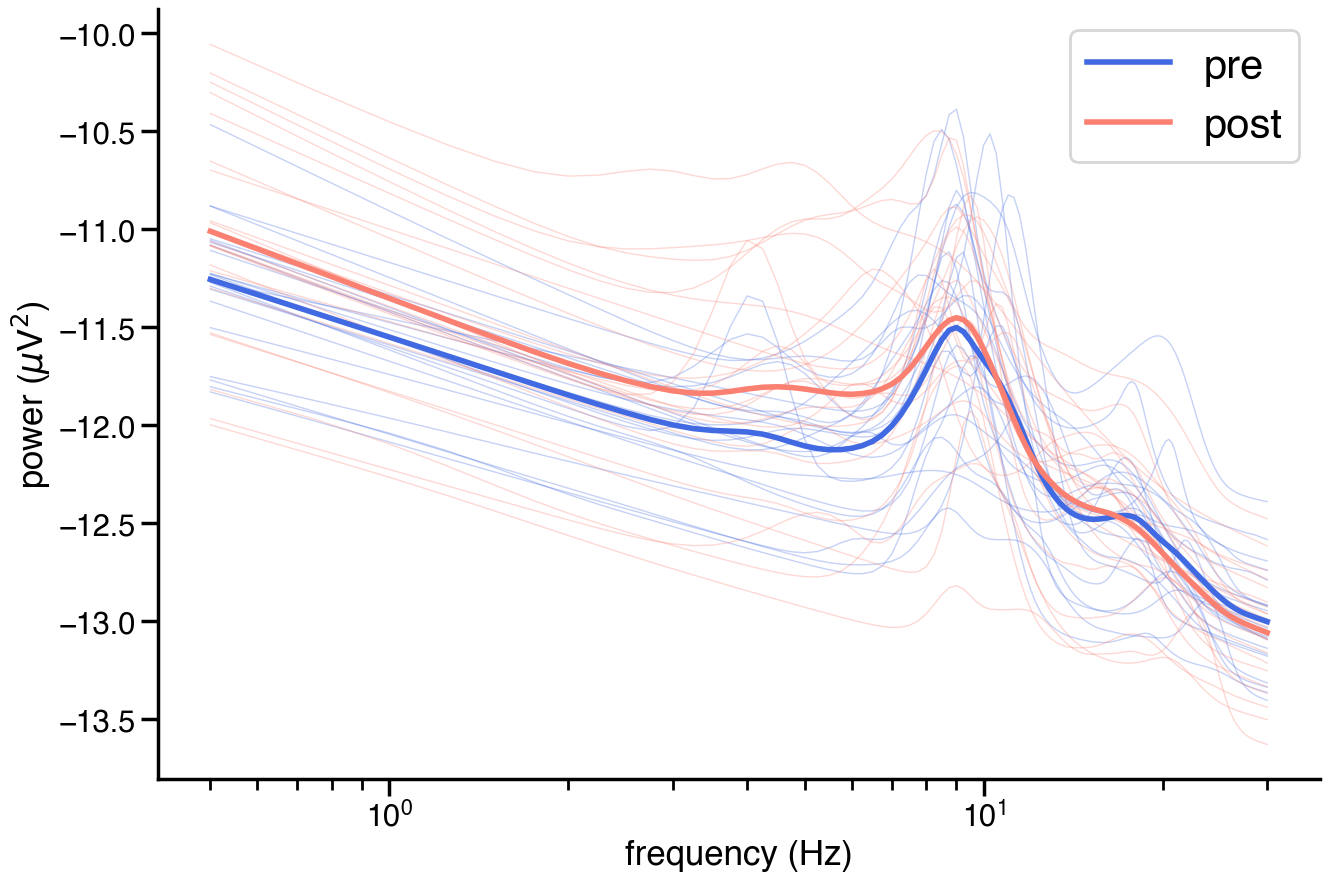

<Figure size 640x480 with 0 Axes>

In [10]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_pre_mean[patient], color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_post_mean[patient], color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], fits_pre_grand_mean, color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], fits_post_grand_mean, color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()
plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

In [11]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_14818/4288182120.py:1: RuntimeWarning: Mean of empty slice
  psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_14818/4288182120.py:2: RuntimeWarning: Mean of empty slice
  psd_post_mean = np.nanmean(psd_post_included, axis=1)


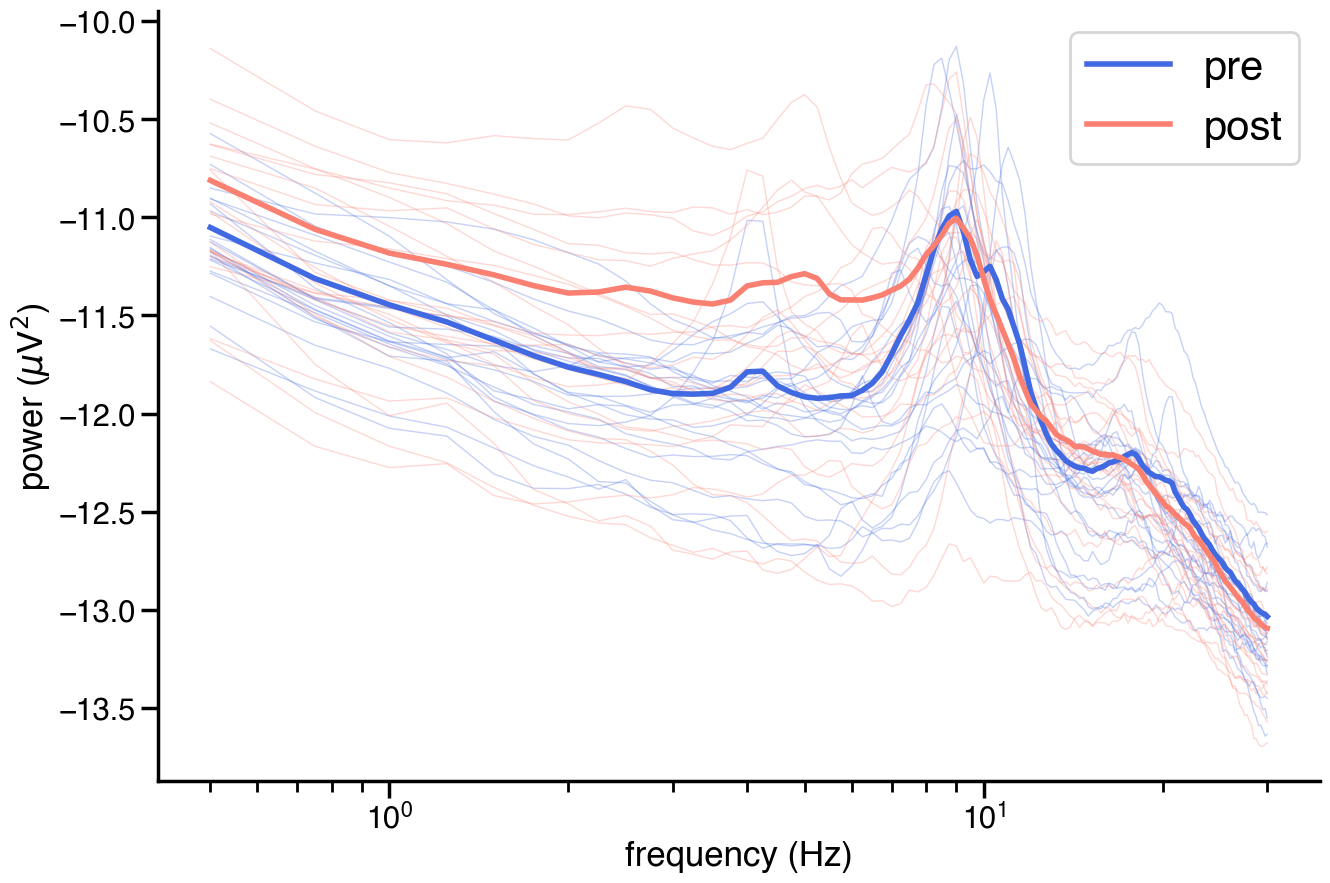

In [12]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], np.log10(psd_pre_mean[patient,2:121]), color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], np.log10(psd_post_mean[patient,2:121]), color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], np.log10(psd_pre_grand_mean[2:121]), color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], np.log10(psd_post_grand_mean[2:121]), color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

## 4. Statistics

### Exponent: Pre/Post

In [13]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['exponent'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.961918  0.528998    True
          W      pval  normal
0  0.950222  0.319068    True


In [14]:
print('exponent pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['exponent'].describe())

exponent pre:
count    22.000000
mean      0.978943
std       0.182696
min       0.632349
25%       0.862424
50%       0.956634
75%       1.076650
max       1.473953
Name: exponent, dtype: float64


In [15]:
print('exponent post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['exponent'].describe())

exponent post:
count    22.000000
mean      1.140282
std       0.219439
min       0.826794
25%       0.973062
50%       1.105218
75%       1.298438
max       1.554722
Name: exponent, dtype: float64


In [16]:
ttest(means_pre, means_post, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.056599,21,two-sided,0.005992,"[-0.27, -0.05]",0.799085,7.658,0.946496


### Delta Oscillatory Power: Pre/Post

In [17]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['delta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.855137  0.033255   False
          W      pval  normal
0  0.955652  0.617365    True


In [18]:
print('delta oscillation power pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['delta_amp'].describe())

delta oscillation power pre:
count    13.000000
mean      0.150633
std       0.145755
min       0.000270
25%       0.040532
50%       0.146205
75%       0.201216
max       0.449523
Name: delta_amp, dtype: float64


In [19]:
print('delta oscillation power post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['delta_amp'].describe())

delta oscillation power post:
count    15.000000
mean      0.353293
std       0.215174
min       0.052810
25%       0.193196
50%       0.332857
75%       0.447621
max       0.822496
Name: delta_amp, dtype: float64


In [20]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC  CLES
Wilcoxon    2.0   two-sided  0.005859 -0.927273  0.19


In [21]:
ttest(means_pre, means_post, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.262753,9,two-sided,0.009796,"[-0.33, -0.06]",1.138636,6.302,0.892036


### Delta Band Power: Pre/Post

In [22]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.962443  0.540178    True
          W      pval  normal
0  0.978363  0.888588    True


In [23]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.88 std: 0.27
post: -11.69 std: 0.51


In [24]:
print('delta band power pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['delta_bp'].describe())

delta band power pre:
count    22.000000
mean    -11.878961
std       0.276800
min     -12.411459
25%     -12.033432
50%     -11.834752
75%     -11.692951
max     -11.321277
Name: delta_bp, dtype: float64


In [25]:
print('delta band power post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['delta_bp'].describe())

delta band power post:
count    22.000000
mean    -11.690437
std       0.520522
min     -12.618929
25%     -11.958731
50%     -11.743806
75%     -11.365566
max     -10.637570
Name: delta_bp, dtype: float64


In [26]:
ttest(means_pre, means_post, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.234293,21,two-sided,0.036466,"[-0.36, -0.01]",0.452237,1.724,0.525461


### Theta Oscillatory Power: Pre/Post

In [27]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.882548  0.019667   False
          W      pval  normal
0  0.923481  0.115631    True


In [28]:
print('theta osc pre')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['theta_amp'].describe())

theta osc pre
count    20.000000
mean      0.360506
std       0.180946
min       0.136073
25%       0.235226
50%       0.354754
75%       0.421651
max       0.910430
Name: theta_amp, dtype: float64


In [29]:
print('theta osc post')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['theta_amp'].describe())

theta osc post
count    20.000000
mean      0.605948
std       0.263550
min       0.195233
25%       0.443773
50%       0.531518
75%       0.817160
max       1.096278
Name: theta_amp, dtype: float64


In [30]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    3.0   two-sided  0.000038 -0.964912  0.188272


In [31]:
cliffs_delta(means_pre, means_post)

(-0.9793388429752066, 'large')

### Theta Band Power: Pre/Post

In [33]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.959907  0.487401    True
          W      pval  normal
0  0.973173  0.783219    True


In [34]:
print('theta band power pre')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['theta_bp'].describe())

theta band power pre
count    22.000000
mean    -12.062872
std       0.384610
min     -12.810843
25%     -12.350328
50%     -12.001241
75%     -11.788927
max     -11.381208
Name: theta_bp, dtype: float64


In [35]:
print('theta band power post')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['theta_bp'].describe())

theta band power post
count    22.000000
mean    -11.788709
std       0.614910
min     -12.962006
25%     -12.079361
50%     -11.769213
75%     -11.413886
max     -10.725504
Name: theta_bp, dtype: float64


In [36]:
ttest(means_pre, means_post, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.190482,21,two-sided,0.0044,"[-0.45, -0.1]",0.534582,9.958,0.666996


### Alpha Oscillatory Power: Pre/Post

In [37]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.964932  0.594816    True
          W      pval  normal
0  0.988872  0.994877    True


In [38]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 1.19 std: 0.44
post: 1.13 std: 0.37


In [39]:
print('alpha oscillation power pre')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['alpha_amp'].describe())

alpha oscillation power pre
count    22.000000
mean      1.188703
std       0.454855
min       0.342445
25%       1.026910
50%       1.147074
75%       1.473293
max       1.991999
Name: alpha_amp, dtype: float64


In [40]:
print('alpha oscillation power post')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['alpha_amp'].describe())

alpha oscillation power post
count    22.000000
mean      1.126985
std       0.379814
min       0.411048
25%       0.900252
50%       1.085621
75%       1.399559
max       1.947471
Name: alpha_amp, dtype: float64


In [41]:
ttest(means_pre, means_post, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.875599,21,two-sided,0.391154,"[-0.08, 0.21]",0.147291,0.314,0.101163


### Alpha Band Power: Pre/Post

In [42]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

         W      pval  normal
0  0.97502  0.823228    True
          W     pval  normal
0  0.958079  0.45146    True


In [43]:
print('alpha band power pre')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['alpha_bp'].describe())

alpha band power pre
count    22.000000
mean    -11.618021
std       0.468994
min     -12.532217
25%     -12.008074
50%     -11.591312
75%     -11.282514
max     -10.843635
Name: alpha_bp, dtype: float64


In [44]:
print('alpha band power post')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['alpha_bp'].describe())

alpha band power post
count    22.000000
mean    -11.591105
std       0.506174
min     -12.909554
25%     -11.800606
50%     -11.513760
75%     -11.213006
max     -10.799351
Name: alpha_bp, dtype: float64


In [45]:
ttest(means_pre, means_post, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.611861,21,two-sided,0.547198,"[-0.12, 0.06]",0.055162,0.264,0.057025


### Delta abundance: Pre/Post

In [46]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_delta_perc'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.607219  0.000002   False
          W      pval  normal
0  0.635455  0.000003   False


In [47]:
print('delta abundance pre')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_delta_perc'].describe())

delta abundance pre
count    22.000000
mean      0.052760
std       0.095577
min       0.000000
25%       0.000000
50%       0.016667
75%       0.066071
max       0.400000
Name: ch_delta_perc, dtype: float64


In [48]:
print('delta abundance post')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_delta_perc'].describe())

delta abundance post
count    22.000000
mean      0.061660
std       0.100524
min       0.000000
25%       0.000000
50%       0.033333
75%       0.052679
max       0.416667
Name: ch_delta_perc, dtype: float64


In [49]:
wilcoxon(means_pre, means_post)

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,73.0,two-sided,0.88699,-0.045752,0.43595


In [50]:
cliffs_delta(means_pre, means_post)

(-0.128099173553719, 'negligible')

### Theta abundance: Pre/Post

In [51]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_theta_perc'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_theta_perc'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.894763  0.023387   False
          W      pval  normal
0  0.847951  0.003124   False


In [52]:
print('theta abundance pre')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_theta_perc'].describe())

theta abundance pre
count    22.000000
mean      0.397538
std       0.336469
min       0.000000
25%       0.066667
50%       0.391667
75%       0.658333
max       0.983333
Name: ch_theta_perc, dtype: float64


In [53]:
print('theta abundance post')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_theta_perc'].describe())

theta abundance post
count    22.000000
mean      0.592524
std       0.374113
min       0.000000
25%       0.210578
50%       0.683333
75%       0.954167
max       1.000000
Name: ch_theta_perc, dtype: float64


In [54]:
wilcoxon(means_pre, means_post)

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,47.0,two-sided,0.018085,-0.593074,0.331612


In [55]:
cliffs_delta(means_pre, means_post)

(-0.3367768595041322, 'medium')

### Alpha abundance: Pre/Post

In [56]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_alpha_perc'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_alpha_perc'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W          pval  normal
0  0.221473  7.416973e-10   False
          W          pval  normal
0  0.486822  9.908147e-08   False


In [57]:
print('alpha abundance pre')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_alpha_perc'].describe())

alpha abundance pre
count    22.000000
mean      0.992424
std       0.035533
min       0.833333
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: ch_alpha_perc, dtype: float64


In [58]:
print('alpha abundance post')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_alpha_perc'].describe())

alpha abundance post
count    22.000000
mean      0.954167
std       0.112386
min       0.533333
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: ch_alpha_perc, dtype: float64


In [59]:
wilcoxon(means_pre, means_post)

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,2.0,two-sided,0.17753,0.733333,0.589876


In [60]:
cliffs_delta(means_pre, means_post)

(0.1797520661157025, 'small')

## 5. Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the band power differences pre vs. post?

#### Standardized Beta Coefficients

Multiple linear regression with z-scored features

In [78]:
features = ['exponent', 'delta_bp', 'delta_amp', 'ch_delta_perc']

# standardizing dataframe
df_z = diff_df_mean[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + delta_amp + ch_delta_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     7.468
Date:                Thu, 19 Oct 2023   Prob (F-statistic):             0.0189
Time:                        09:42:55   Log-Likelihood:                -6.4156
No. Observations:                  10   AIC:                             20.83
Df Residuals:                       6   BIC:                             22.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.776e-17      0.188   1.48e-16

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [79]:
features = ['exponent', 'theta_bp', 'theta_amp', 'ch_theta_perc']

# standardizing dataframe
df_z = diff_df_mean[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('theta_bp ~ exponent + theta_amp + ch_theta_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     47.61
Date:                Thu, 19 Oct 2023   Prob (F-statistic):           1.36e-07
Time:                        09:42:55   Log-Likelihood:                -3.7965
No. Observations:                  18   AIC:                             15.59
Df Residuals:                      14   BIC:                             19.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.939e-17      0.080   8.69e-16

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [81]:
features = ['exponent', 'alpha_bp', 'alpha_amp', 'ch_alpha_perc']

# standardizing dataframe
df_z = diff_df_mean[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     6.626
Date:                Thu, 19 Oct 2023   Prob (F-statistic):            0.00329
Time:                        09:43:00   Log-Likelihood:                -23.033
No. Observations:                  22   AIC:                             54.07
Df Residuals:                      18   BIC:                             58.43
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.163e-17      0.162   2.56e-16

# Transform datafame

In [82]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 
# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post']

In [83]:
# Rename columns to add pre and post labels
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
diff_df_mean = diff_df_mean.rename(columns={c: 'diff_'+c for c in diff_df_mean.columns if c not in ['patient']})

In [85]:
# Merge pre and post back together
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
# Merge pre and post with difference dataframe
eeg_pre_post_diff = pd.merge(eeg_pre_post, diff_df_mean, on='patient', how='left')

In [86]:
# Drop some column labels that don't make sense
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [87]:
# Dataframe: each row is a patient, each column has a pre, post, and diff value
eeg_pre_post_diff.head()

,patient,pre_exponent,pre_offset,pre_delta_amp,pre_delta_bp,pre_theta_amp,pre_theta_bp,pre_theta_cf,pre_delta_cf,pre_alpha_amp,...,diff_theta_amp,diff_theta_bp,diff_theta_cf,diff_delta_cf,diff_alpha_amp,diff_alpha_bp,diff_alpha_cf,diff_ch_theta_perc,diff_ch_delta_perc,diff_ch_alpha_perc
0,9,1.473953,-10.917829,0.146205,-11.321277,0.406346,-11.572985,5.350125,2.005953,1.024964,...,-0.126412,0.217771,-0.261639,NaN,-0.033321,0.237228,-0.192199,-0.416667,0.033333,0.000
1,10,0.918883,-12.048699,0.040532,-12.365095,0.186566,-12.690452,6.482045,2.453152,0.544296,...,NaN,0.271554,NaN,1.442773,0.133248,0.377337,-0.243519,0.071429,0.017857,0.125
2,18,1.210897,-11.247657,0.000270,-11.664588,0.347279,-11.836585,5.256519,2.749999,1.125067,...,-0.142301,0.134673,-1.168109,1.732426,0.012111,-0.016471,-0.024781,0.266667,0.000000,0.000
3,22,1.127844,-11.422851,NaN,-11.830947,0.452602,-11.993586,6.542572,NaN,1.711845,...,-0.236117,-0.450002,0.208337,NaN,0.285625,-0.103030,0.006089,0.000000,0.000000,0.000
4,25,0.978264,-11.362823,NaN,-11.694787,0.362230,-12.026519,6.619937,NaN,1.167903,...,0.107728,0.323614,1.483623,NaN,-0.779568,-0.284728,-0.800650,0.118644,-0.033898,0.000


In [88]:

eeg_pre_post_diff.to_csv('../saved_files/mst_files/mst_pre_post_diff_df.csv')